# CS 6375 – Project 4 Code: K-Means & EM (GMM)

This notebook implements:

- Part 1 – K-Means clustering using sklearn.cluster.KMeans  
  Datasets: make_blobs and make_moons  
  k ∈ {2, 3, 4, 5}  
  Initialization: random vs k-means++  
  Visualizations: scatter plots and centers  
  Metrics: Silhouette score and inertia  

- Part 2 – EM via Gaussian Mixture Models  
  Using sklearn.mixture.GaussianMixture  
  k ∈ {2, 3, 4, 5}  
  Covariance types: full and diag  
  Visualizations: scatter plots and Gaussian ellipses  
  Metrics: Silhouette score, log-likelihood, BIC  



# Import and global Settings

In [ ]:
import numpy as np
import pandas as pd

from sklearn.datasets import make_blobs, make_moons
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score

import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

import warnings
warnings.filterwarnings("ignore")

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

## Generate Synthetic 2D Datasets

We create two datasets used throughout the project:

- make_blobs: spherical, well-separated clusters  
- make_moons: non-linear, non-spherical structure  

Each dataset has about 200 points for clear visualization.


In [ ]:
# This function generates the synthetic 2D datasets used in both K-Means and GMM experiments.
def generate_synthetic_datasets(sample_count=200, noise_level=0.08, random_state=RANDOM_STATE):
    blob_features, blob_true_labels = make_blobs(
        n_samples=sample_count,
        centers=3,
        cluster_std=1.0,
        random_state=random_state,
    )

    moon_features, moon_true_labels = make_moons(
        n_samples=sample_count,
        noise=noise_level,
        random_state=random_state,
    )

    all_datasets = {
        "blobs": (blob_features, blob_true_labels),
        "moons": (moon_features, moon_true_labels),
    }
    return all_datasets


datasets_by_name = generate_synthetic_datasets()

for dataset_name, (feature_matrix, true_label_vector) in datasets_by_name.items():
    print(f"{dataset_name}: feature_matrix shape = {feature_matrix.shape}, true_label_vector shape = {true_label_vector.shape}")

blobs: feature_matrix shape = (200, 2), true_label_vector shape = (200,)
moons: feature_matrix shape = (200, 2), true_label_vector shape = (200,)


## Helper Functions for Plotting

This cell defines:

- plot_kmeans_clusters: scatter plot for K-Means clusters with centers
- make_gaussian_ellipse: build an ellipse for a Gaussian component
- plot_gmm_clusters_with_ellipses: scatter plot for GMM clusters with Gaussian ellipses


In [ ]:
# This function plots 2D clustered data with optional centers for K-Means.
def plot_kmeans_clusters(feature_matrix, cluster_labels, cluster_centers=None, plot_title=None, axis=None):
    if axis is None:
        figure, axis = plt.subplots(figsize=(5, 4))

    axis.scatter(feature_matrix[:, 0], feature_matrix[:, 1], c=cluster_labels, s=25, cmap="viridis")

    if cluster_centers is not None:
        axis.scatter(
            cluster_centers[:, 0],
            cluster_centers[:, 1],
            s=150,
            c="red",
            marker="X",
            edgecolor="black",
            linewidth=1.5,
        )

    axis.set_xlabel("Feature 1")
    axis.set_ylabel("Feature 2")

    if plot_title is not None:
        axis.set_title(plot_title)

    return axis


# This function creates a 2D Gaussian ellipse for visualization.
def make_gaussian_ellipse(center_vector, covariance_matrix, standard_deviation_radius=2.0, **ellipse_kwargs):
    eigenvalues, eigenvectors = np.linalg.eigh(covariance_matrix)
    sort_order = eigenvalues.argsort()[::-1]
    eigenvalues, eigenvectors = eigenvalues[sort_order], eigenvectors[:, sort_order]

    angle_degrees = np.degrees(np.arctan2(*eigenvectors[:, 0][::-1]))
    axis_length_1, axis_length_2 = 2 * standard_deviation_radius * np.sqrt(eigenvalues)

    ellipse = Ellipse(
        xy=center_vector,
        width=axis_length_1,
        height=axis_length_2,
        angle=angle_degrees,
        **ellipse_kwargs,
    )
    return ellipse


# This function plots GMM clusters and their covariance ellipses.
def plot_gmm_clusters_with_ellipses(feature_matrix, cluster_labels, fitted_gmm_model, plot_title=None, axis=None):
    if axis is None:
        figure, axis = plt.subplots(figsize=(5, 4))

    axis.scatter(feature_matrix[:, 0], feature_matrix[:, 1], c=cluster_labels, s=25, cmap="viridis")

    for mean_vector, covariance_entry in zip(fitted_gmm_model.means_, fitted_gmm_model.covariances_):
        if covariance_entry.ndim == 1:
            covariance_matrix = np.diag(covariance_entry[:2])
        else:
            covariance_matrix = covariance_entry[:2, :2]

        ellipse = make_gaussian_ellipse(
            center_vector=mean_vector[:2],
            covariance_matrix=covariance_matrix,
            standard_deviation_radius=2.0,
            edgecolor="red",
            facecolor="none",
            linewidth=1.5,
        )
        axis.add_patch(ellipse)

    axis.set_xlabel("Feature 1")
    axis.set_ylabel("Feature 2")

    if plot_title is not None:
        axis.set_title(plot_title)

    return axis

## Helper Functions for Running Experiments

This cell defines functions to:

- Run K-Means for several values of k and initialization methods
- Run GMM for several values of k and covariance types
- Collect metrics into pandas DataFrames

In [ ]:
# This function runs K-Means for a range of cluster counts and initialization methods, and returns a DataFrame of metrics.
def run_kmeans_experiments(feature_matrix, dataset_name, cluster_count_list, init_method_list):
    experiment_records = []

    for cluster_count in cluster_count_list:
        for init_method in init_method_list:
            kmeans_model = KMeans(
                n_clusters=cluster_count,
                init=init_method,
                n_init=10,
                random_state=RANDOM_STATE,
            )
            kmeans_model.fit(feature_matrix)

            cluster_labels = kmeans_model.labels_

            if len(np.unique(cluster_labels)) > 1:
                silhouette_value = silhouette_score(feature_matrix, cluster_labels)
            else:
                silhouette_value = np.nan

            experiment_records.append(
                {
                    "dataset_name": dataset_name,
                    "cluster_count": cluster_count,
                    "init_method": init_method,
                    "silhouette_score": silhouette_value,
                    "inertia_value": kmeans_model.inertia_,
                }
            )

    result_frame = pd.DataFrame(experiment_records)
    return result_frame


# This function runs GMM for a range of component counts and covariance types, and returns a DataFrame of metrics.
def run_gmm_experiments(feature_matrix, dataset_name, component_count_list, covariance_type_list):
    experiment_records = []

    for component_count in component_count_list:
        for covariance_type_name in covariance_type_list:
            gmm_model = GaussianMixture(
                n_components=component_count,
                covariance_type=covariance_type_name,
                random_state=RANDOM_STATE,
            )
            gmm_model.fit(feature_matrix)
            cluster_labels = gmm_model.predict(feature_matrix)

            if len(np.unique(cluster_labels)) > 1:
                silhouette_value = silhouette_score(feature_matrix, cluster_labels)
            else:
                silhouette_value = np.nan

            average_log_likelihood = gmm_model.score(feature_matrix)
            bic_value = gmm_model.bic(feature_matrix)

            experiment_records.append(
                {
                    "dataset_name": dataset_name,
                    "component_count": component_count,
                    "covariance_type": covariance_type_name,
                    "silhouette_score": silhouette_value,
                    "average_log_likelihood": average_log_likelihood,
                    "bic_value": bic_value,
                }
            )

    result_frame = pd.DataFrame(experiment_records)
    return result_frame

## Part 1 – K-Means Clustering

We now run K-Means on each dataset using:

- cluster_count in {2, 3, 4, 5}
- init_method in {"random", "k-means++"}

We display the metrics table and show scatter plots for k-means++ for each cluster count.



K-Means experiments for dataset: blobs


,dataset_name,cluster_count,init_method,silhouette_score,inertia_value
0,blobs,2,random,0.706617,3720.112349
1,blobs,2,k-means++,0.706617,3720.112349
2,blobs,3,random,0.846700,364.473321
3,blobs,3,k-means++,0.846700,364.473321
4,blobs,4,random,0.678049,319.882562
5,blobs,4,k-means++,0.679849,314.873350
6,blobs,5,random,0.509465,273.619951
7,blobs,5,k-means++,0.509465,273.619951


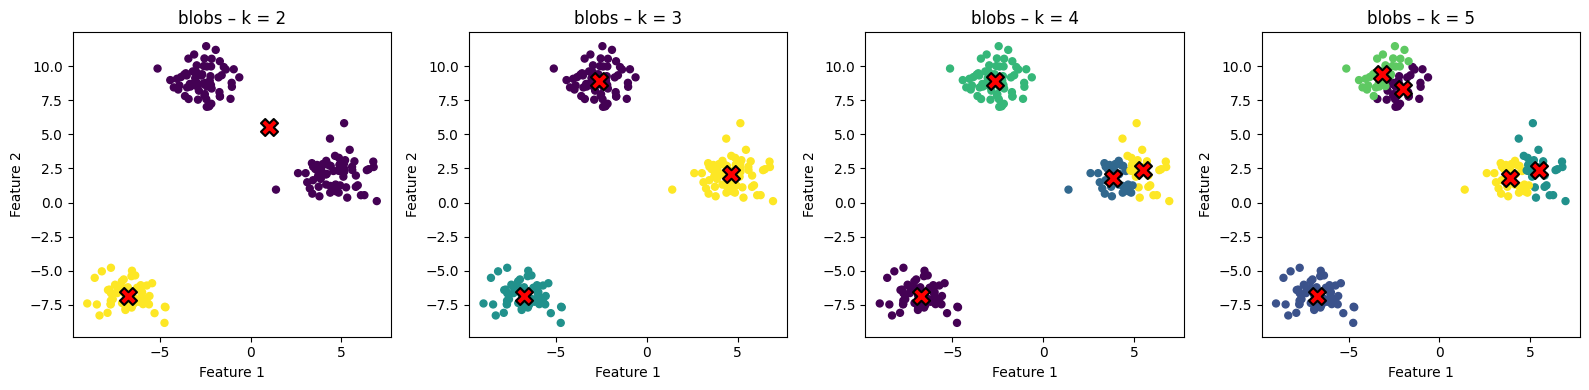


K-Means experiments for dataset: moons


,dataset_name,cluster_count,init_method,silhouette_score,inertia_value
0,moons,2,random,0.479929,83.016316
1,moons,2,k-means++,0.479929,83.016316
2,moons,3,random,0.420366,55.285174
3,moons,3,k-means++,0.422985,55.284277
4,moons,4,random,0.455618,35.374154
5,moons,4,k-means++,0.455077,35.358250
6,moons,5,random,0.478501,26.133177
7,moons,5,k-means++,0.480317,26.145928


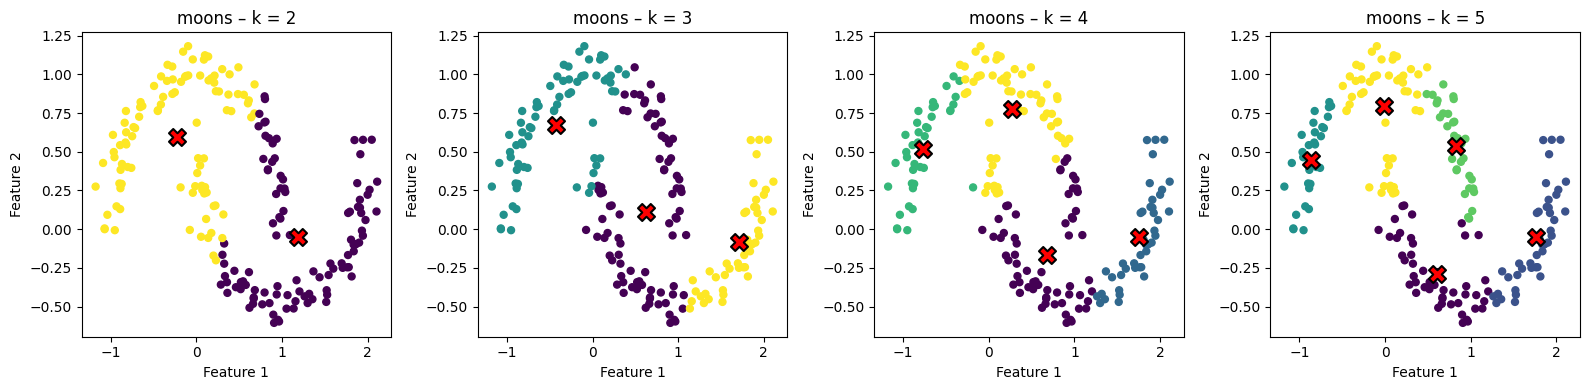

Combined K-Means results:


,dataset_name,cluster_count,init_method,silhouette_score,inertia_value
0,blobs,2,random,0.706617,3720.112349
1,blobs,2,k-means++,0.706617,3720.112349
2,blobs,3,random,0.846700,364.473321
3,blobs,3,k-means++,0.846700,364.473321
4,blobs,4,random,0.678049,319.882562
5,blobs,4,k-means++,0.679849,314.873350
6,blobs,5,random,0.509465,273.619951
7,blobs,5,k-means++,0.509465,273.619951
8,moons,2,random,0.479929,83.016316
9,moons,2,k-means++,0.479929,83.016316


In [ ]:
kmeans_cluster_count_list = [2, 3, 4, 5]
kmeans_init_method_list = ["random", "k-means++"]

all_kmeans_result_frames = []

for dataset_name, (feature_matrix, true_label_vector) in datasets_by_name.items():
    print(f"\nK-Means experiments for dataset: {dataset_name}")
    kmeans_result_frame = run_kmeans_experiments(
        feature_matrix=feature_matrix,
        dataset_name=dataset_name,
        cluster_count_list=kmeans_cluster_count_list,
        init_method_list=kmeans_init_method_list,
    )
    all_kmeans_result_frames.append(kmeans_result_frame)
    display(kmeans_result_frame)

    figure, axis_array = plt.subplots(1, len(kmeans_cluster_count_list), figsize=(4 * len(kmeans_cluster_count_list), 4))

    for axis, cluster_count in zip(axis_array, kmeans_cluster_count_list):
        kmeans_model = KMeans(
            n_clusters=cluster_count,
            init="k-means++",
            n_init=10,
            random_state=RANDOM_STATE,
        )
        kmeans_model.fit(feature_matrix)

        plot_kmeans_clusters(
            feature_matrix=feature_matrix,
            cluster_labels=kmeans_model.labels_,
            cluster_centers=kmeans_model.cluster_centers_,
            plot_title=f"{dataset_name} – k = {cluster_count}",
            axis=axis,
        )

    plt.tight_layout()
    plt.show()

combined_kmeans_results = pd.concat(all_kmeans_result_frames, ignore_index=True)
print("Combined K-Means results:")
display(combined_kmeans_results)

## Elbow Plots for K-Means

This cell creates inertia vs cluster_count plots (elbow method) for each dataset and each initialization method.


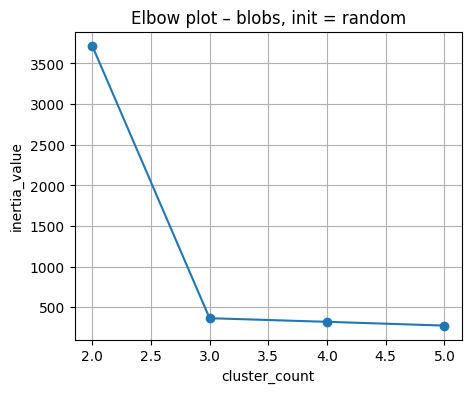

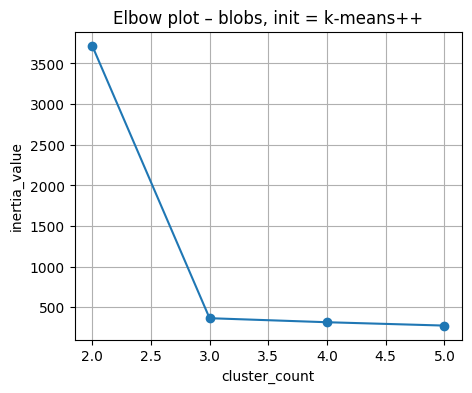

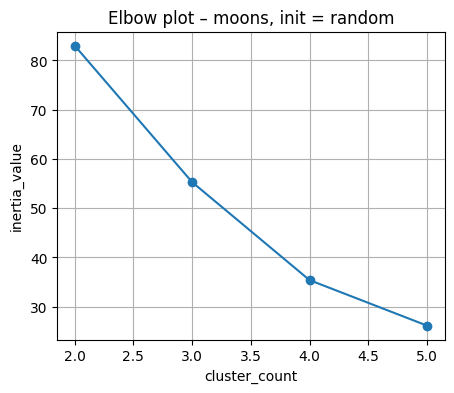

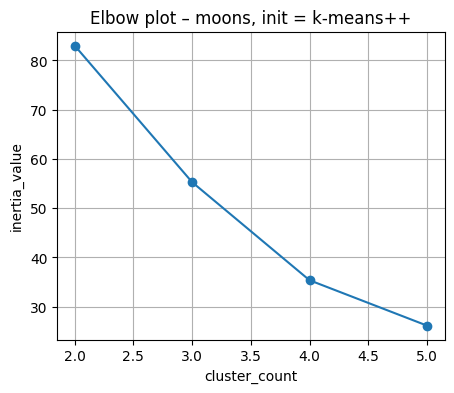

In [ ]:
# This function plots inertia versus cluster_count for a given dataset and initialization method.
def plot_kmeans_elbow(combined_result_frame, dataset_name, init_method):
    filtered_frame = (
        combined_result_frame[
            (combined_result_frame["dataset_name"] == dataset_name)
            & (combined_result_frame["init_method"] == init_method)
        ]
        .sort_values("cluster_count")
    )

    plt.figure(figsize=(5, 4))
    plt.plot(filtered_frame["cluster_count"], filtered_frame["inertia_value"], marker="o")
    plt.title(f"Elbow plot – {dataset_name}, init = {init_method}")
    plt.xlabel("cluster_count")
    plt.ylabel("inertia_value")
    plt.grid(True)
    plt.show()


for dataset_name in datasets_by_name.keys():
    for init_method in kmeans_init_method_list:
        plot_kmeans_elbow(combined_kmeans_results, dataset_name, init_method)

## Part 2 – EM with Gaussian Mixture Models

We now run GaussianMixture (EM) clustering on each dataset using:

- component_count in {2, 3, 4, 5}
- covariance_type in {"full", "diag"}

We display the metrics table and show scatter plots with Gaussian ellipses for covariance_type = "full".


GMM experiments for dataset: blobs


,dataset_name,component_count,covariance_type,silhouette_score,average_log_likelihood,bic_value
0,blobs,2,full,0.519518,-4.739742,1954.178092
1,blobs,2,diag,0.519518,-5.607928,2290.856184
2,blobs,3,full,0.846700,-3.823259,1619.375098
3,blobs,3,diag,0.846700,-3.829603,1606.017620
4,blobs,4,full,0.666481,-3.817704,1648.942825
5,blobs,4,diag,0.662793,-3.828153,1631.929310
6,blobs,5,full,0.503397,-3.795893,1672.008508
7,blobs,5,diag,0.493045,-3.813983,1652.752980


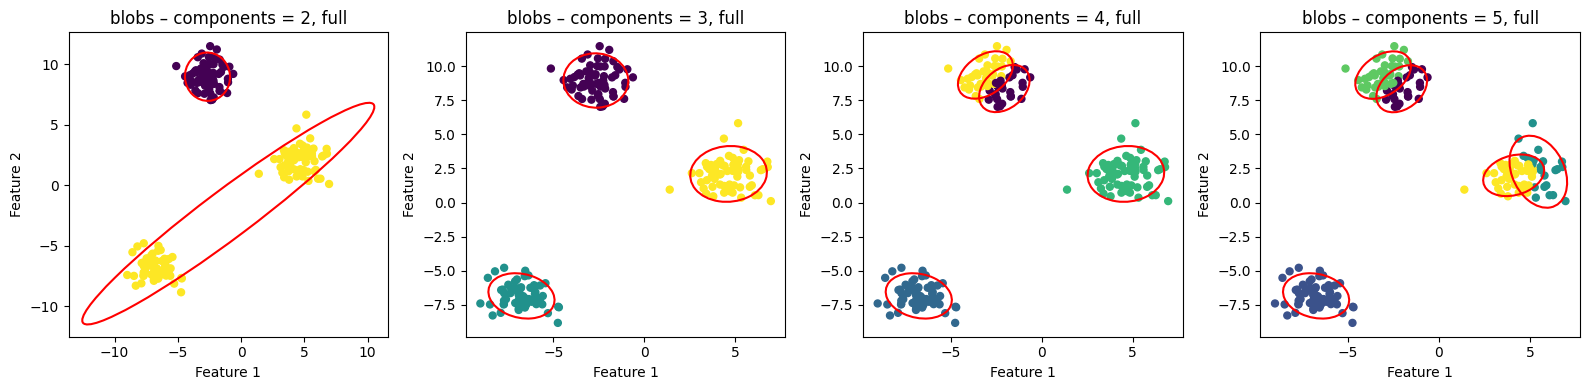


GMM experiments for dataset: moons


,dataset_name,component_count,covariance_type,silhouette_score,average_log_likelihood,bic_value
0,moons,2,full,0.459472,-1.730802,750.602293
1,moons,2,diag,0.457767,-1.768522,755.093527
2,moons,3,full,0.400461,-1.453709,671.555061
3,moons,3,diag,0.410668,-1.752421,775.144982
4,moons,4,full,0.453257,-1.270043,629.878339
5,moons,4,diag,0.372125,-1.437724,675.757637
6,moons,5,full,0.456296,-1.092853,590.792314
7,moons,5,diag,0.393023,-1.367242,674.056453


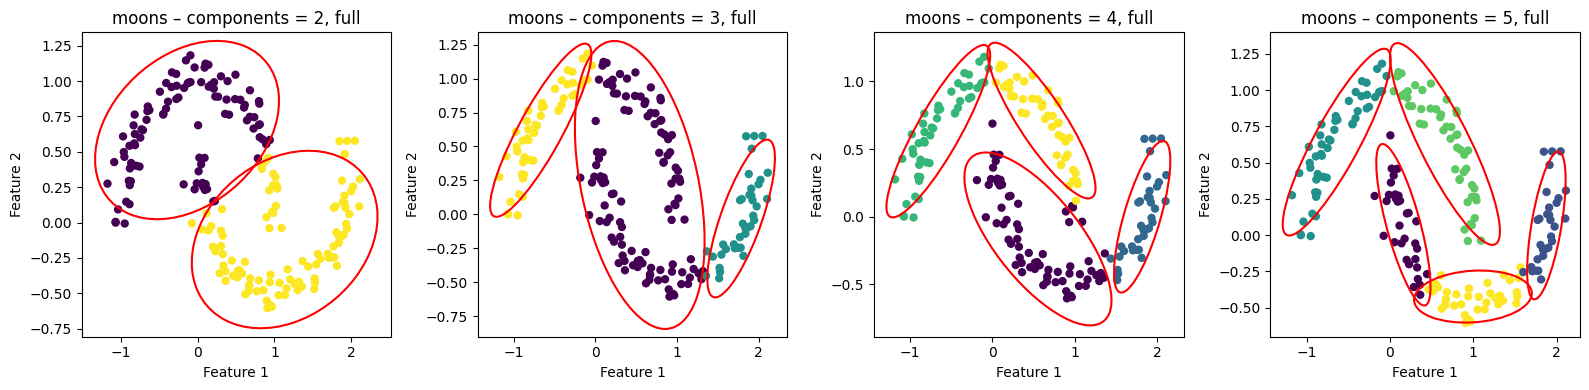

Combined GMM results:


,dataset_name,component_count,covariance_type,silhouette_score,average_log_likelihood,bic_value
0,blobs,2,full,0.519518,-4.739742,1954.178092
1,blobs,2,diag,0.519518,-5.607928,2290.856184
2,blobs,3,full,0.846700,-3.823259,1619.375098
3,blobs,3,diag,0.846700,-3.829603,1606.017620
4,blobs,4,full,0.666481,-3.817704,1648.942825
5,blobs,4,diag,0.662793,-3.828153,1631.929310
6,blobs,5,full,0.503397,-3.795893,1672.008508
7,blobs,5,diag,0.493045,-3.813983,1652.752980
8,moons,2,full,0.459472,-1.730802,750.602293
9,moons,2,diag,0.457767,-1.768522,755.093527


In [ ]:
gmm_component_count_list = [2, 3, 4, 5]
gmm_covariance_type_list = ["full", "diag"]

all_gmm_result_frames = []

for dataset_name, (feature_matrix, true_label_vector) in datasets_by_name.items():
    print(f"\nGMM experiments for dataset: {dataset_name}")
    gmm_result_frame = run_gmm_experiments(
        feature_matrix=feature_matrix,
        dataset_name=dataset_name,
        component_count_list=gmm_component_count_list,
        covariance_type_list=gmm_covariance_type_list,
    )
    all_gmm_result_frames.append(gmm_result_frame)
    display(gmm_result_frame)

    figure, axis_array = plt.subplots(1, len(gmm_component_count_list), figsize=(4 * len(gmm_component_count_list), 4))

    for axis, component_count in zip(axis_array, gmm_component_count_list):
        gmm_model = GaussianMixture(
            n_components=component_count,
            covariance_type="full",
            random_state=RANDOM_STATE,
        )
        gmm_model.fit(feature_matrix)
        cluster_labels = gmm_model.predict(feature_matrix)

        plot_gmm_clusters_with_ellipses(
            feature_matrix=feature_matrix,
            cluster_labels=cluster_labels,
            fitted_gmm_model=gmm_model,
            plot_title=f"{dataset_name} – components = {component_count}, full",
            axis=axis,
        )

    plt.tight_layout()
    plt.show()

combined_gmm_results = pd.concat(all_gmm_result_frames, ignore_index=True)
print("Combined GMM results:")
display(combined_gmm_results)

## Summary Tables for Metrics

This cell builds summary tables for:

- K-Means results grouped by dataset_name, cluster_count, init_method
- GMM results grouped by dataset_name, component_count, covariance_type

In [ ]:
# This function summarizes K-Means experiment metrics into a grouped DataFrame.
def summarize_kmeans_results(combined_result_frame):
    grouped_frame = (
        combined_result_frame
        .groupby(["dataset_name", "cluster_count", "init_method"])
        .agg(
            mean_silhouette=("silhouette_score", "mean"),
            mean_inertia=("inertia_value", "mean"),
        )
        .reset_index()
    )
    return grouped_frame


# This function summarizes GMM experiment metrics into a grouped DataFrame.
def summarize_gmm_results(combined_result_frame):
    grouped_frame = (
        combined_result_frame
        .groupby(["dataset_name", "component_count", "covariance_type"])
        .agg(
            mean_silhouette=("silhouette_score", "mean"),
            mean_average_log_likelihood=("average_log_likelihood", "mean"),
            mean_bic=("bic_value", "mean"),
        )
        .reset_index()
    )
    return grouped_frame


print("K-Means summary:")
kmeans_summary_frame = summarize_kmeans_results(combined_kmeans_results)
display(kmeans_summary_frame)

print("\nGMM summary:")
gmm_summary_frame = summarize_gmm_results(combined_gmm_results)
display(gmm_summary_frame)

K-Means summary:


,dataset_name,cluster_count,init_method,mean_silhouette,mean_inertia
0,blobs,2,k-means++,0.706617,3720.112349
1,blobs,2,random,0.706617,3720.112349
2,blobs,3,k-means++,0.846700,364.473321
3,blobs,3,random,0.846700,364.473321
4,blobs,4,k-means++,0.679849,314.873350
5,blobs,4,random,0.678049,319.882562
6,blobs,5,k-means++,0.509465,273.619951
7,blobs,5,random,0.509465,273.619951
8,moons,2,k-means++,0.479929,83.016316
9,moons,2,random,0.479929,83.016316



GMM summary:


,dataset_name,component_count,covariance_type,mean_silhouette,mean_average_log_likelihood,mean_bic
0,blobs,2,diag,0.519518,-5.607928,2290.856184
1,blobs,2,full,0.519518,-4.739742,1954.178092
2,blobs,3,diag,0.846700,-3.829603,1606.017620
3,blobs,3,full,0.846700,-3.823259,1619.375098
4,blobs,4,diag,0.662793,-3.828153,1631.929310
5,blobs,4,full,0.666481,-3.817704,1648.942825
6,blobs,5,diag,0.493045,-3.813983,1652.752980
7,blobs,5,full,0.503397,-3.795893,1672.008508
8,moons,2,diag,0.457767,-1.768522,755.093527
9,moons,2,full,0.459472,-1.730802,750.602293
